In [1]:
from datetime import datetime
import random
import sys
sys.path.append('..')

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from itertools import chain, combinations
from collections import Counter


from utils.data import (
    read_comscore_demo_df,
    income_groups_4_comscore_mapping,
    income_groups_4,
    race_groups
)

# Demonstrating Browsing Differences by Income and Race Demographic Groups

A core question in our analysis of FLoC's sensitivity is whether demographic groups in our dataset exhibit significant browsing behavior differences. If users' browsing history does not vary by demographic group, then we should expect any clustering algorithm, including FLoC, to group independently of these demographics. We use a Chi-Squared test to test if each of our demographic groups' browsing behaviors are independent from their demographic, treating each demographic group as a separate population, and the top domains visited in our dataset as the categorical variable of interest. 

We define demographic groups by either the racial background categories, or the household income groups. We test for income and race separately.

To calculate domain visit frequencies, we construct a set $D_w^m$ consisting of each unique domain visited by a machine $m$ in a given week $w$. 

### Data setup

In [2]:
# read in preprocessed weeks-machines data
wmd_simhash_fpath = '../output/wmd_simhash.csv'
wmd_df = pd.read_csv(wmd_simhash_fpath)
print('read in %s total rows' % len(wmd_df))
wmd_df.head()

read in 4877236 total rows


,machine_id,week,n_domains,domains,simhash
0,169007206,1,104,"{'2dopeboyz.com', 'offers.com', 'wordpress.com...",1.585204e+14
1,170331223,1,0,set(),NaN
2,170422065,1,20,"{'shein.com', 'refinery29.com', 'messenger.com...",5.322881e+14
3,170911221,1,49,"{'8haodangpu.cc', 'vjav.com', '51luoben.com', ...",7.213568e+14
4,171771316,1,64,"{'youtube.com', 'thingames.com', 'hudsonsfurni...",6.710488e+14


In [3]:
comscore_demo_df = (
    read_comscore_demo_df(fpath="../data/comscore/{year}/demographics.csv", year=2017)
    .assign(machine_id=lambda x: x.machine_id.astype(int))
)
df = (
    wmd_df.merge(
        comscore_demo_df, 
        how='inner',
        left_on='machine_id', 
        right_on='machine_id'
    ).query("n_domains > 0"))
# map comescore coded household_income to our 4 income groups
df.household_income = df.household_income.map(
    income_groups_4_comscore_mapping
)
# use names for household_income and racial_background
df.household_income = df.household_income.map(income_groups_4)
df.racial_background = df.racial_background.map(race_groups)
df.head(3)

,machine_id,week,n_domains,domains,simhash,household_income,racial_background
0,169007206,1,104,"{'2dopeboyz.com', 'offers.com', 'wordpress.com...",1.585204e+14,"\$25,000 - $75,000",black
1,169007206,2,78,"{'2dopeboyz.com', 'findallnorthatlantahomesfor...",7.578056e+14,"\$25,000 - $75,000",black
2,169007206,3,77,"{'2dopeboyz.com', 'allposters.com', 'personali...",1.193749e+14,"\$25,000 - $75,000",black


In [4]:
# just keep the columns we need
df = df[['machine_id','domains','household_income','racial_background']]
# fix domains: unfortunately domains is a string looking like a set.
# convert it to a list
def do_replacements(d): # b/c I'm too lazy to write a regex
    for r in ['{', '}', '\'', '\t', ' ']: d = d.replace(r, '')
    return d
df.domains = df.domains.apply(do_replacements).apply(lambda d: d.split(','))

In [5]:
df.head(3)

,machine_id,domains,household_income,racial_background
0,169007206,"[2dopeboyz.com, offers.com, wordpress.com, ora...","\$25,000 - $75,000",black
1,169007206,"[2dopeboyz.com, findallnorthatlantahomesforsal...","\$25,000 - $75,000",black
2,169007206,"[2dopeboyz.com, allposters.com, personalizer.i...","\$25,000 - $75,000",black


What is N? 

For each race group?

For each income group?

In [6]:
print('N=%s' % len(df), '\n')
print(df.groupby('racial_background').count()['machine_id'], '\n')
print(df.groupby('household_income').count()['machine_id'])

N=3057867 

racial_background
asian     205811
black     501090
other     434987
white    1915979
Name: machine_id, dtype: int64 

household_income
\$150,000 or more       312147
\$25,000 - $75,000     1298709
\$75,000 - $150,000     771334
less than $25,000       675677
Name: machine_id, dtype: int64


We calculate the overall distribution of domain visits, across all demographic groups. We later use this to compute the top N domains visited in our dataset:

In [7]:
domain_freqs = pd.Series(Counter(chain.from_iterable(df.domains)))
all_distribution = (pd.DataFrame(domain_freqs)
                    .reset_index()
                    .rename({'index': 'domain', 0: 'count'}, axis=1)
                    .set_index('domain')
                    .assign(p=lambda x: x['count'] / x['count'].sum())
                    .sort_values('count', ascending=False)
)
# all_distribution.head()

To validate the chi-square tests, we also generate a random sample population with an N equal to 1/4 our total population. We uniformly sample across all users. We assign a fake, new demographic identifier 'random control'. This allows us to compare chi-square significance between this control group and the other demographic groups.

In [8]:
# random sample
# we plant a random seed because counts and therefore 
# p-values for the random sample will change without consistent sampling
random.seed('hi FLoC') 
controls_df = (df.sample(n = round(len(df) * 0.25))
           .assign(racial_background = 'random control')
           .assign(household_income = 'random control')
          )
df = pd.concat([df, controls_df])
df.head()

,machine_id,domains,household_income,racial_background
0,169007206,"[2dopeboyz.com, offers.com, wordpress.com, ora...","\$25,000 - $75,000",black
1,169007206,"[2dopeboyz.com, findallnorthatlantahomesforsal...","\$25,000 - $75,000",black
2,169007206,"[2dopeboyz.com, allposters.com, personalizer.i...","\$25,000 - $75,000",black
3,169007206,"[2dopeboyz.com, redbubble.com, youtube.com, in...","\$25,000 - $75,000",black
4,169007206,"[writersbeat.com, youtube.com, apple.com, adbl...","\$25,000 - $75,000",black


#### Set up browsing behavior distributions for racial groups

We calculate the frequencies at which each domain appears in the weekly unique domain list for each racial group. This is our categorical distribution, across all races.

In [9]:
# Calculate frequencies for each race group
start_time = datetime.now()
freqs = []
for race in df.racial_background.unique():
    df2 = df[df.racial_background == race]
    counter = pd.Series(Counter(chain.from_iterable(df2.domains)))
    freqs.append(counter)

end_time = datetime.now()
time = end_time - start_time
print('took %s' % (time))

took 0:00:34.802691


In [10]:
races = df.racial_background.unique()
dfs = [(pd.DataFrame(distribution)
       .assign(race=races[i])) for i, distribution in enumerate(freqs)]

race_distributions = (pd.concat(dfs)
                      .reset_index()
                      .rename({'index': 'domain', 0: 'count'}, axis=1)
                     )
total_counts = race_distributions.groupby('race')['count'].sum()
race_distributions['p'] = race_distributions.apply(lambda x: x['count']/total_counts[x['race']], axis=1)

In [ ]:
# race_distributions.sort_values('p', ascending=False).head(10)

#### Set up browsing behavior distributions for income groups

The same as for race groups.

In [12]:
# Calculate frequencies for each income group
t1 = datetime.now()
freqs = []
income_groups = df.household_income.unique()
for income in income_groups:
    df2 = df[df.household_income == income]
    counter = pd.Series(Counter(chain.from_iterable(df2.domains)))
    freqs.append(counter)

t2 = datetime.now()
print('part 1 took %s' % (t2-t1))

dfs = [(pd.DataFrame(freq)
       .assign(income=income_groups[i])) for i, freq in enumerate(freqs)]
income_distributions = (pd.concat(dfs)
                      .reset_index()
                      .rename({'index': 'domain', 0: 'count'}, axis=1)
                     )
total_counts = income_distributions.groupby('income')['count'].sum()
income_distributions['p'] = income_distributions.apply(lambda x: x['count']/total_counts[x['income']], axis=1)
t3 = datetime.now()
print('part 2 took %s' % (t3-t2))

part 1 took 0:00:35.376759
part 2 took 0:02:07.429567


### Chi-Square tests

Rather than using Chi-Square to test whether all groups are from the same underlying distribution, we construct a series of pairwise Chi-Square tests.

In [13]:
MAX_D = 100

from scipy.stats import chi2_contingency


def chi_square_data(top_domains, demo_distributions, demo_col):
    demo_dist_df = demo_distributions[demo_distributions.domain.isin(top_domains.index)]
    demo_X = (demo_dist_df
     [['domain', demo_col, 'count']]
     .pivot(index='domain', columns=demo_col)
    )
    return demo_X

def chi_square_overall(N, all_dist_df, demo_distributions, demo_col):
    """
    N: N top domains from the aggregated population to consider
    all_dist_df: dataframe of 'all_distribution'
    """
    top_domains = all_dist_df.nlargest(N, columns='p')
    demo_X = chi_square_data(top_domains, demo_distributions, demo_col)
    df = demo_X['count']
    results = []
    for col in df.columns:
        X = pd.concat([df[col], top_domains['count']], axis=1).values
        results.append(chi2_contingency(X))
    return results

def chi_square_pairwise(N, all_dist_df, demo_distributions, demo_col):
    top_domains = all_dist_df.nlargest(N, columns='p')
    demo_X = chi_square_data(top_domains, demo_distributions, demo_col)
    pairs = combinations([c[1] for c in demo_X.columns], r=2)
    df = demo_X['count']
    results = []
    for c1, c2 in pairs:
        X = pd.concat([df[c1], df[c2]], axis=1).values
        results.append(chi2_contingency(X)) # chi2, p, dof, ex = chi2_contingency(X)
    return results

In [14]:
race_X = chi_square_data(
    all_distribution.nlargest(MAX_D, columns='p'),
    race_distributions, 'race'
)
# avoid showing output numbers for comscore data terms of service
# race_X.sort_values(('count', 'random control'), ascending=False).head()

In [15]:
income_X = chi_square_data(
    all_distribution.nlargest(MAX_D, columns='p'),
    income_distributions, 'income'
)
# avoid showing output numbers for comscore data terms of service
# income_X.sort_values(('count', 'random control'), ascending=False).head()

In [16]:
race_results = []
for N in np.arange(10, MAX_D+10, 10):
    overall = chi_square_overall(N, all_distribution, 
                                 race_distributions, 'race')
    pairwise = chi_square_pairwise(N, all_distribution,
                                   race_distributions, 'race')
    overall_p = [r[1] for r in overall]
    pairwise_p = [r[1] for r in pairwise]
    race_results.append((N, overall_p, pairwise_p))

print("Overall dataframe for race:")
Ns = [r[0] for r in race_results]
# get results for overall chi-sq. pairwise is in r[2]
pvals = [r[1] for r in race_results] 
chi_df = pd.DataFrame(pvals, columns=race_X['count'].columns)
chi_df['N'] = Ns
chi_df

Overall dataframe for race:


race,asian,black,other,random control,white,N
0,0.0,0.0,0.0,0.932331,0.0,10
1,0.0,0.0,0.0,0.995509,0.0,20
2,0.0,0.0,0.0,0.785838,0.0,30
3,0.0,0.0,0.0,0.847188,0.0,40
4,0.0,0.0,0.0,0.968896,0.0,50
5,0.0,0.0,0.0,0.994308,0.0,60
6,0.0,0.0,0.0,0.948534,0.0,70
7,0.0,0.0,0.0,0.982918,0.0,80
8,0.0,0.0,0.0,0.992033,0.0,90
9,0.0,0.0,0.0,0.997428,0.0,100


In [17]:
income_results = []
for N in np.arange(10, MAX_D+10, 10):
    overall = chi_square_overall(N, all_distribution, 
                                 income_distributions, 'income')
    pairwise = chi_square_pairwise(N, all_distribution,
                                   income_distributions, 'income')
    overall_p = [r[1] for r in overall]
    pairwise_p = [r[1] for r in pairwise]
    income_results.append((N, overall_p, pairwise_p))

print("Overall dataframe:")
pvals = [r[1] for r in income_results]
Ns = [r[0] for r in income_results]
chi_df = pd.DataFrame(pvals, columns=income_X['count'].columns)
chi_df['N'] = Ns
chi_df

Overall dataframe:


income,"\$150,000 or more","\$25,000 - $75,000","\$75,000 - $150,000","less than $25,000",random control,N
0,0.0,1.009358e-253,0.0,0.0,0.932331,10
1,0.0,0.000000e+00,0.0,0.0,0.995509,20
2,0.0,0.000000e+00,0.0,0.0,0.785838,30
3,0.0,0.000000e+00,0.0,0.0,0.847188,40
4,0.0,0.000000e+00,0.0,0.0,0.968896,50
5,0.0,0.000000e+00,0.0,0.0,0.994308,60
6,0.0,0.000000e+00,0.0,0.0,0.948534,70
7,0.0,0.000000e+00,0.0,0.0,0.982918,80
8,0.0,0.000000e+00,0.0,0.0,0.992033,90
9,0.0,0.000000e+00,0.0,0.0,0.997428,100


---
# Plots

While the Chi-Square test demonstrates that there *is* a difference in browsing behavior between demographic groups (both income and race groups), it doesn't show the degree of that difference. To get a sense for differences in behavior, plots displaying distributions over domain frequencies are below.

In [18]:
# Take just the top 50 domains for plotting
top_domains_50 = all_distribution.nlargest(50, columns='p')
# Sorted by domain frequency (by p for domain in top domains)
income_top_50_df = income_distributions.set_index('domain').loc[top_domains_50.index]
race_top_50_df = race_distributions.set_index('domain').loc[top_domains_50.index]

In [19]:
# income_top_50_df.head(16)

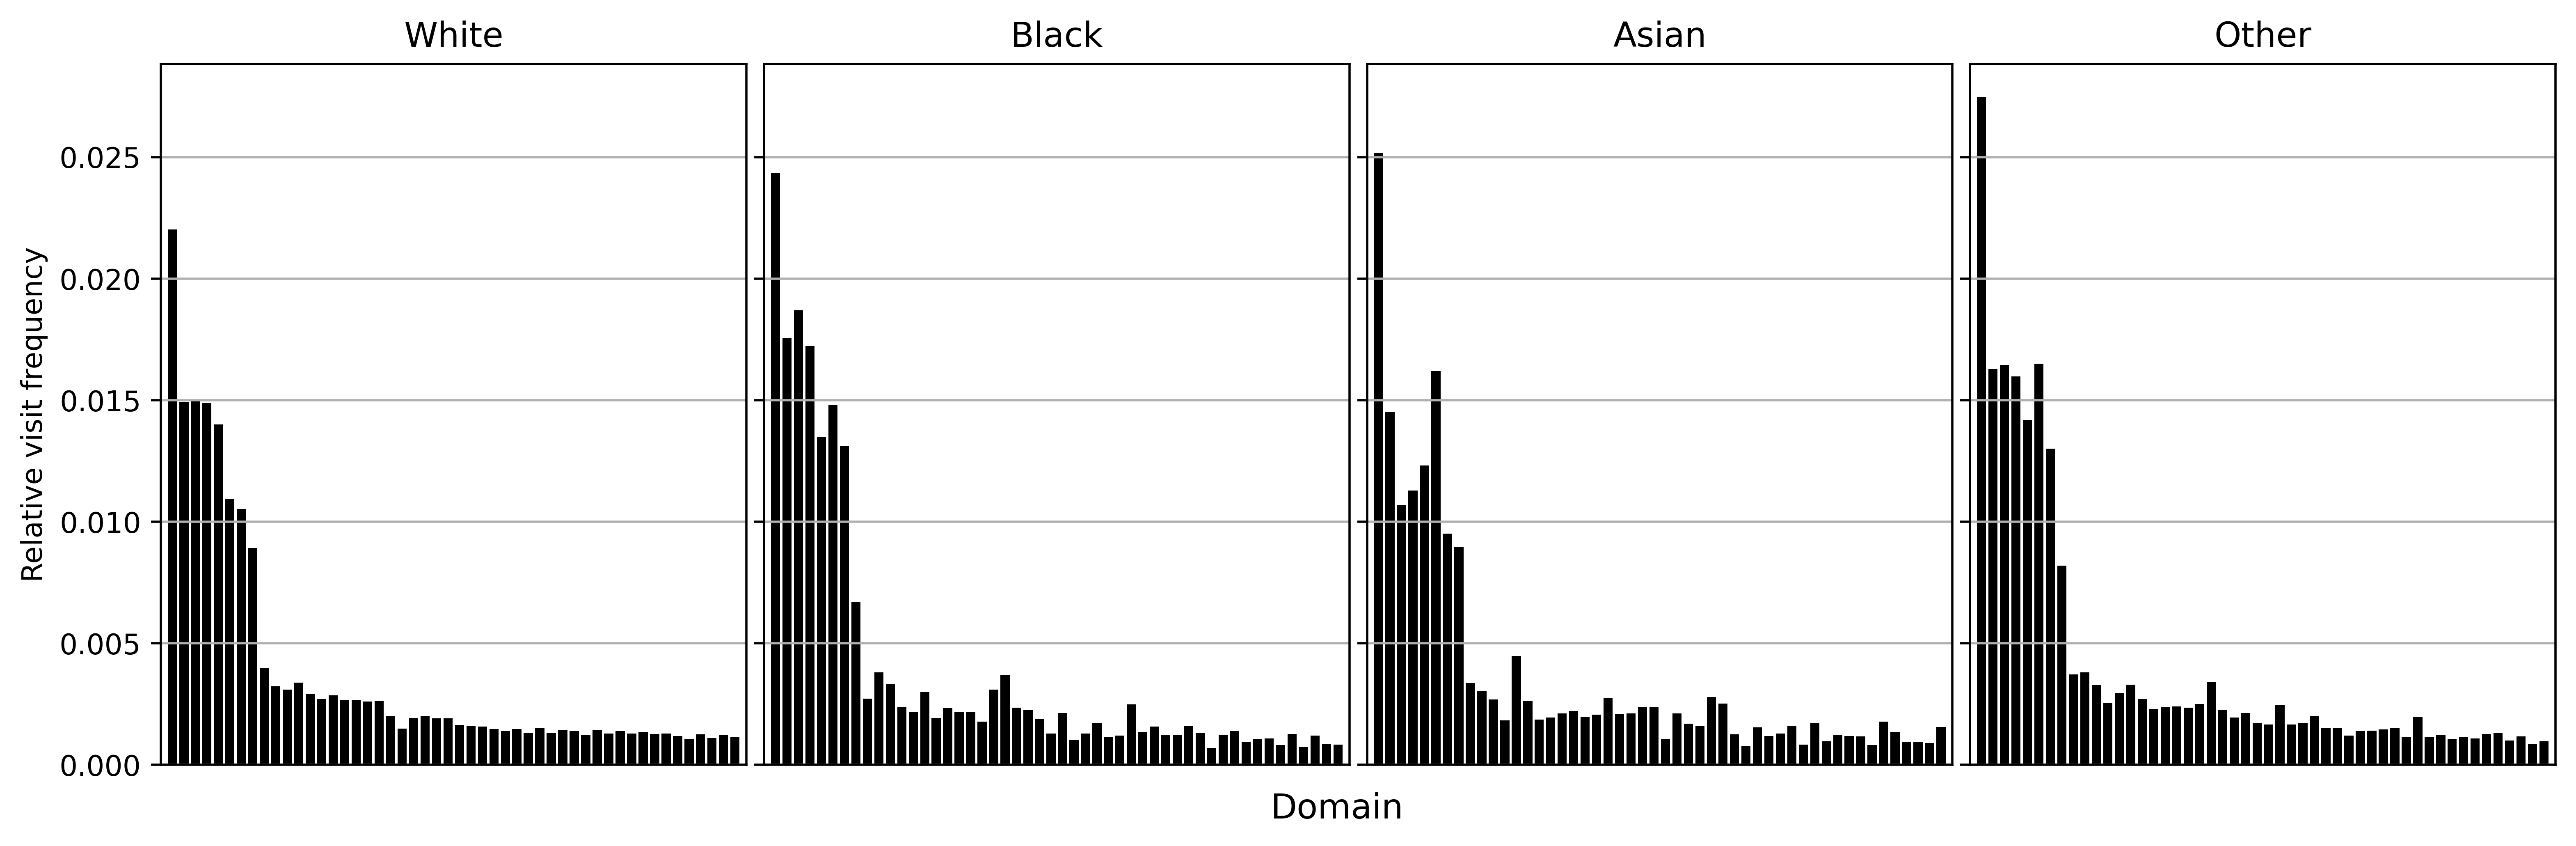

In [20]:
fig, axes = plt.subplots(1, 4, figsize=(4*3.1, 4), dpi=500, 
                         sharey=True, sharex=True)
plt.tight_layout()
plt.subplots_adjust(wspace=0.03)
for i, race in enumerate(['white','black','asian','other']):
    ax = axes[i]
    p_df = race_top_50_df[race_top_50_df.race==race]
    ax.grid(True)
    ax.bar(p_df.index, p_df.p, color='black')
    ax.set_title(race.capitalize())
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_xlim(-1,50)
    
_ = axes[0].set_ylabel('Relative visit frequency')
fig.text(0.5, 0.03, 'Domain', fontsize='large', ha='center', color='black')
plt.show()

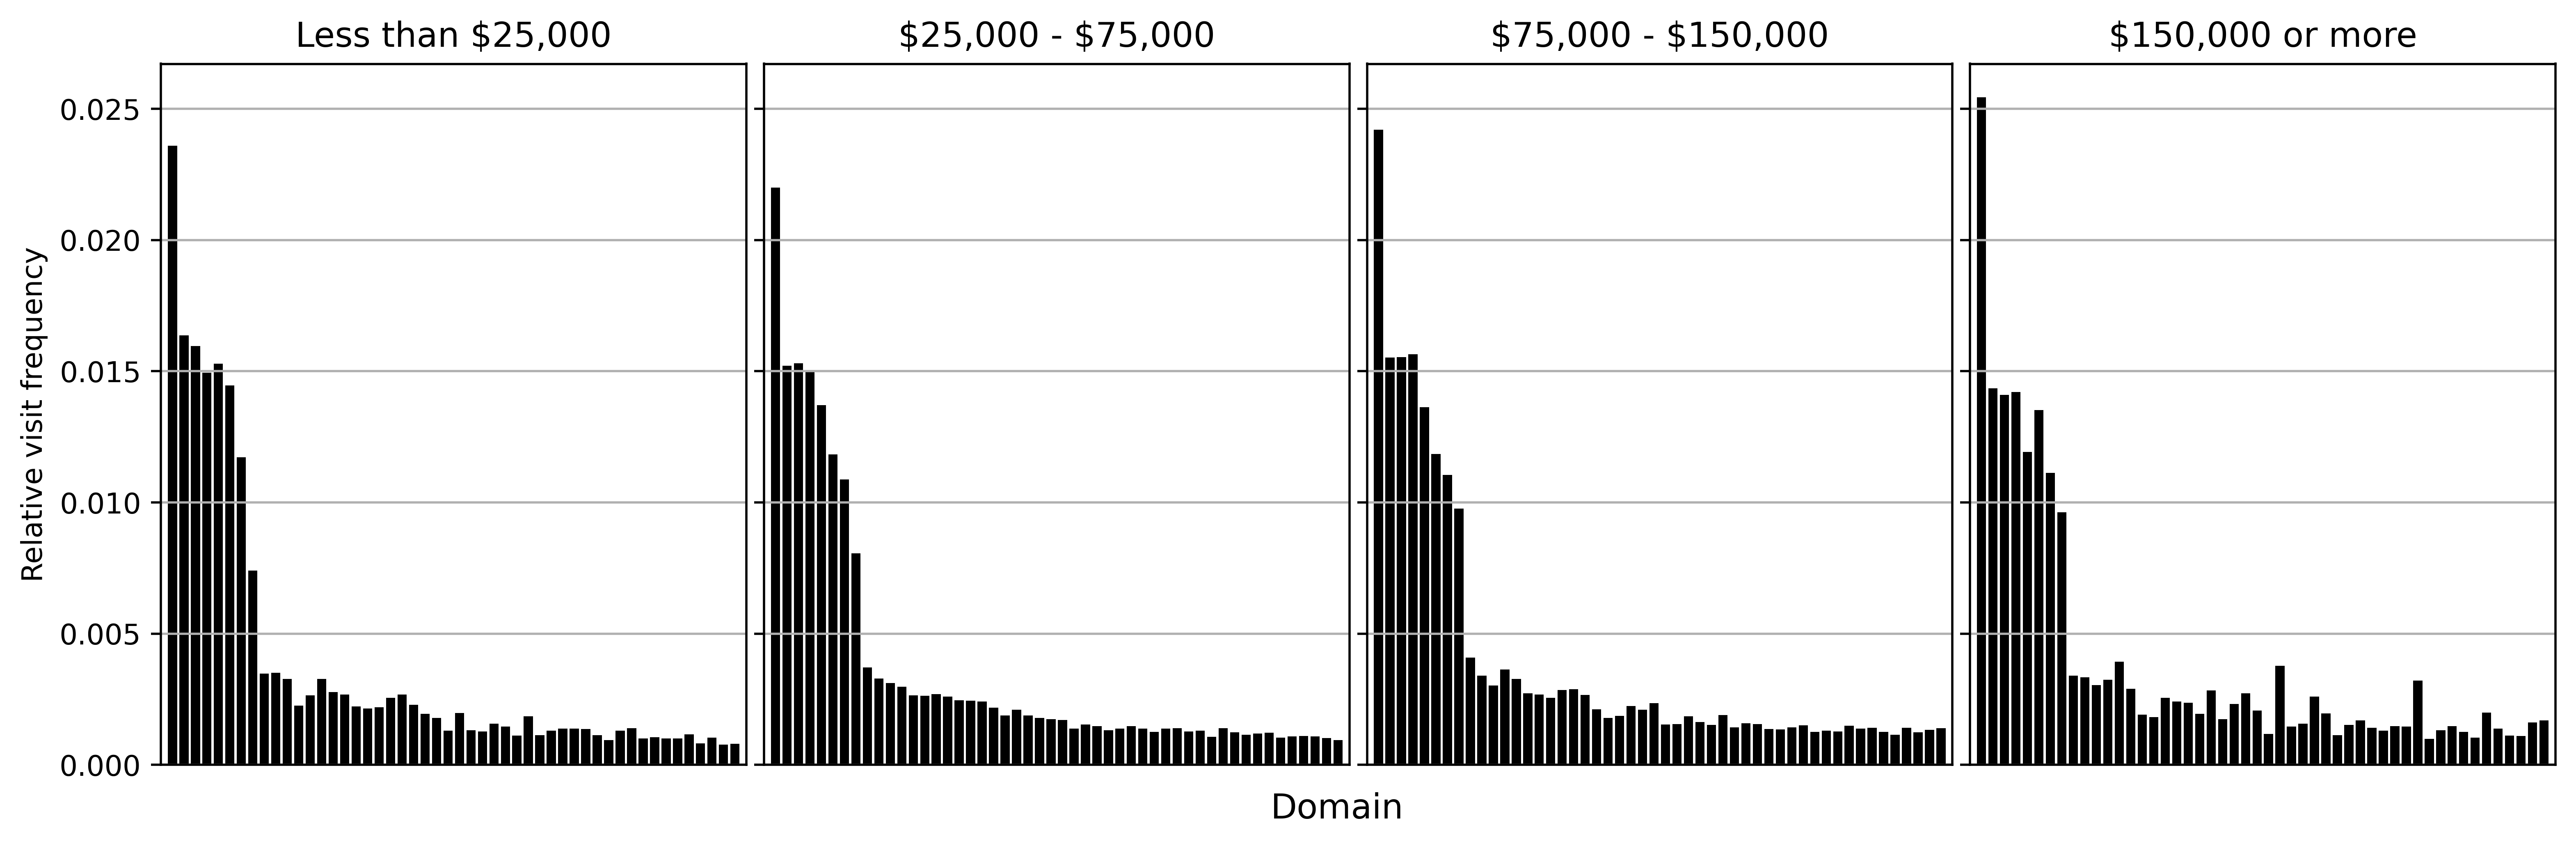

In [21]:
fig, axes = plt.subplots(1, 4, figsize=(4*3.1, 4), dpi=500, 
                         sharey=True, sharex=True)
plt.tight_layout()
plt.subplots_adjust(wspace=0.03)
for i, income in enumerate(income_groups_4.values()):
    ax = axes[i]
    p_df = income_top_50_df[income_top_50_df.income==income]
    ax.grid(True)
    ax.bar(p_df.index, p_df.p, color='black')
    ax.set_title(income.capitalize())
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_xlim(-1,50)
    
_ = axes[0].set_ylabel('Relative visit frequency')
fig.text(0.5, 0.03, 'Domain', fontsize='large', ha='center', color='black')
plt.show()

Although the distributions are generally shaped similarly, there are significant differences in overall frequencies to the top few sites overall.

# Table: Browsing distributions, top D

Aggregating across weeks for each racial group, this gives us a distribution over all domains in our dataset. For example, here are the top D domains visited by each racial group in the comscore data.

But wait, for our comScore data agreement, we cannot show data that connects domain names with traffic data.

So we get creative.

In [22]:
top_domains_100 = all_distribution.nlargest(100, columns='p')
income_top_100_df = income_distributions.set_index('domain').loc[top_domains_100.index]
race_top_100_df = race_distributions.set_index('domain').loc[top_domains_100.index]

In [23]:
top_browsing_df = (
    race_top_100_df.reset_index().groupby('race')
    .apply(lambda x: x.nlargest(100, columns='p'))
    [['domain', 'race', 'p']]
    .pivot(index='domain', columns='race')
    ['p']
    .reset_index().rename_axis(['index'])
    .merge(income_top_100_df.reset_index().groupby('income')
        .apply(lambda x: x.nlargest(100, columns='p'))
        [['domain', 'income', 'p']]
        .pivot(index='domain', columns='income')
        ['p']
        .reset_index().rename_axis(['index'])
    )
    .set_index('domain')
    .assign(overall=lambda x: x.index.map(all_distribution.p))
    .applymap(lambda x: '{0:.2%}'.format(x))
    .sort_values('overall', ascending=False)
    # re-order the columns
    [['overall','random control'] \
     + ['white','black','asian','other'] \
     + list(income_groups_4.values())]
    .reset_index()
)
top_browsing_df.index = top_browsing_df.index + 1
print(len(top_browsing_df))
top_browsing_df.drop('domain', axis=1).head()

100


,overall,random control,white,black,asian,other,"less than $25,000","\$25,000 - $75,000","\$75,000 - $150,000","\$150,000 or more"
1,2.32%,2.31%,2.20%,2.44%,2.52%,2.75%,2.36%,2.20%,2.42%,2.54%
2,1.54%,1.54%,1.49%,1.76%,1.45%,1.63%,1.64%,1.52%,1.55%,1.43%
3,1.54%,1.52%,1.50%,1.87%,1.07%,1.65%,1.60%,1.53%,1.55%,1.41%
4,1.51%,1.50%,1.49%,1.72%,1.13%,1.60%,1.49%,1.50%,1.56%,1.42%
5,1.38%,1.37%,1.40%,1.35%,1.23%,1.42%,1.53%,1.37%,1.36%,1.19%


In [24]:
print(top_browsing_df.drop('domain',axis=1).to_latex())

\begin{tabular}{lllllllllll}
\toprule
{} & overall & random control &  white &  black &  asian &  other & less than \$25,000 & \textbackslash \$25,000 - \$75,000 & \textbackslash \$75,000 - \$150,000 & \textbackslash \$150,000 or more \\
\midrule
1   &   2.32\% &          2.31\% &  2.20\% &  2.44\% &  2.52\% &  2.75\% &             2.36\% &              2.20\% &               2.42\% &             2.54\% \\
2   &   1.54\% &          1.54\% &  1.49\% &  1.76\% &  1.45\% &  1.63\% &             1.64\% &              1.52\% &               1.55\% &             1.43\% \\
3   &   1.54\% &          1.52\% &  1.50\% &  1.87\% &  1.07\% &  1.65\% &             1.60\% &              1.53\% &               1.55\% &             1.41\% \\
4   &   1.51\% &          1.50\% &  1.49\% &  1.72\% &  1.13\% &  1.60\% &             1.49\% &              1.50\% &               1.56\% &             1.42\% \\
5   &   1.38\% &          1.37\% &  1.40\% &  1.35\% &  1.23\% &  1.42\% &             1.53\% &      

In [26]:
# print out the top domain names in alphabetical order
top_100_domains_alphabetical_df = pd.DataFrame({
    'domain':sorted(top_browsing_df.domain.apply(str.strip).values)
})
top_100_domains_alphabetical_df.index = top_100_domains_alphabetical_df.index + 1
top_100_domains_alphabetical_df

,domain
1,247-inc.net
2,adobe.com
3,adp.com
4,amazon.com
5,aol.com
...,...
96,yahoo.com
97,yelp.com
98,youporn.com
99,youtube.com


In [27]:
print(top_100_domains_alphabetical_df.to_latex())

\begin{tabular}{ll}
\toprule
{} &                 domain \\
\midrule
1   &            247-inc.net \\
2   &              adobe.com \\
3   &                adp.com \\
4   &             amazon.com \\
5   &                aol.com \\
6   &              apple.com \\
7   &                ask.com \\
8   &                att.com \\
9   &      bangcreatives.com \\
10  &      bankofamerica.com \\
11  &            bestbuy.com \\
12  &               bing.com \\
13  &          bongacams.com \\
14  &              btrll.com \\
15  &           camdolls.com \\
16  &         capitalone.com \\
17  &              chase.com \\
18  &         chaturbate.com \\
19  &               citi.com \\
20  &                cnn.com \\
21  &            comcast.net \\
22  &         craigslist.org \\
23  &            dropbox.com \\
24  &               ebay.com \\
25  &     elbowviewpoint.com \\
26  &               espn.com \\
27  &               etsy.com \\
28  &            expedia.com \\
29  &           facebook.com \\
30 